Привет, меня зовут Артем. Сегодня я проверю твой проект.
<br> Дальнейшее общение будет происходить на "ты" если это не вызывает никаких проблем.
<br> Желательно реагировать на каждый мой комментарий ('исправил', 'не понятно как исправить ошибку', ...)
<br> Пожалуйста, не удаляй комментарии ревьюера, так как они повышают качество повторного ревью.

Комментарии будут в <font color='green'>зеленой</font>, <font color='blue'>синей</font> или <font color='red'>красной</font> рамках:

<div class="alert alert-block alert-success">
<b>Успех:</b> Если все сделано отлично
</div>

<div class="alert alert-block alert-info">
<b>Совет: </b> Если можно немного улучшить
</div>

<div class="alert alert-block alert-danger">
<b>Ошибка:</b> Если требуются исправления. Работа не может быть принята с красными комментариями.
</div>

-------------------

Будет очень хорошо, если ты будешь помечать свои действия следующим образом:
<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b> ...
</div>

<div class="alert alert-block alert-warning">
<b>Изменения:</b> Были внесены следующие изменения ...
</div>

#### <font color='orange'>Полезные ссылки:</font>
* Полезная лекция про временные ряды: https://www.youtube.com/watch?v=u433nrxdf5k .

### <font color='orange'>Общее впечатление</font>
* Большое спасибо за проделанную работу. Видно, что приложено много усилий.
* Отлично, что ноутбук хорошо структурирован. Приятно проверять такие работы.
* Над этим проектом нужно будет еще немного поработать. Однако, изменения не должны занять много времени.
* В работе я оставил несколько советов. Буду рад, если ты учтешь их.
* С радостью отвечу на твои вопросы, если они есть. Лучше всего их собрать в следующей ячейке. Жду новую версию проекта.

<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b> Рад знакомству, Артем! По организационным моментам все опнял!
</div>


### <font color='orange'>Общее впечатление (ревью 2)</font>
* После исправлений проект улучшился и теперь он может быть зачтен.
* Для удобства все новые комментарии обозначены фразой "ревью 2".
* Удачи в дальнейшем обучении и следующих работах!

# Компания «Чётенькое такси»

**Введение**

Полученные данные содержат исторические данные о заказах такси в аэропортах. Название файла - `/datasets/taxi.csv`.

**Цель работы**

Спрогнозировать количество заказов на следующий час.

**Ход работы**

1. Загрузка данных. Ресемплирование по одному часу.
2. Анализ данных.
3. Обучение моделей с разными гиперпараметрами.
4. Анализ времени обучения. Проверка данных на тестовой выборке.

## Загрузка данных. Ресемплирование по одному часу.

Подключим необходимые библиотеки.

In [19]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import time
import math

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
import pylab

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit


from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
# import xgboost as xgb
import catboost as cb

from sklearn.metrics import mean_squared_error

## from statsmodels.tsa.stattools import adfuller
## statsmodels.tsa.arima_model import ARIMA

RANDOM_STATE = 12345


Выгрузим данные в переменную `data`.

In [20]:
try:
    data = pd.read_csv('/datasets/taxi.csv')
except Exception:
    data = pd.read_csv('taxi.csv')

data.head(5)

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [21]:
len(data)

26496

Приведем столбец `datetime` к временному типу. Заменим индексы на столбец `datetime`.

In [22]:
data.datetime = pd.to_datetime(data.datetime)
data = data.set_index(data.datetime)

Выполним ресемплирование по одному часу.

In [27]:
data = data.resample('1H').sum(numeric_only=True)
data.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Данные успешно преобразованы.

## Анализ данных


Проанализируем данные. Выполним следующие пункты:

1. Проверим, в хронологическом ли порядке расположены даты и время.
2. Посмотрим на скользящие среднее и стандартное отклонение.
3. Разложим ряд на компоненты: тренд, cезонность, случайные колебания.
4. Построим график автокорреляции.

Проверим, в хронологическом ли порядке расположены даты и время.

In [28]:
print(f'Расположены ли данные в хронологическом порядке порядке: {"Да!" if data.index.is_monotonic_increasing else "Нет!"}')

Расположены ли данные в хронологическом порядке порядке: Да!


Посмотрим на скользящие среднее и стандартное отклонение.

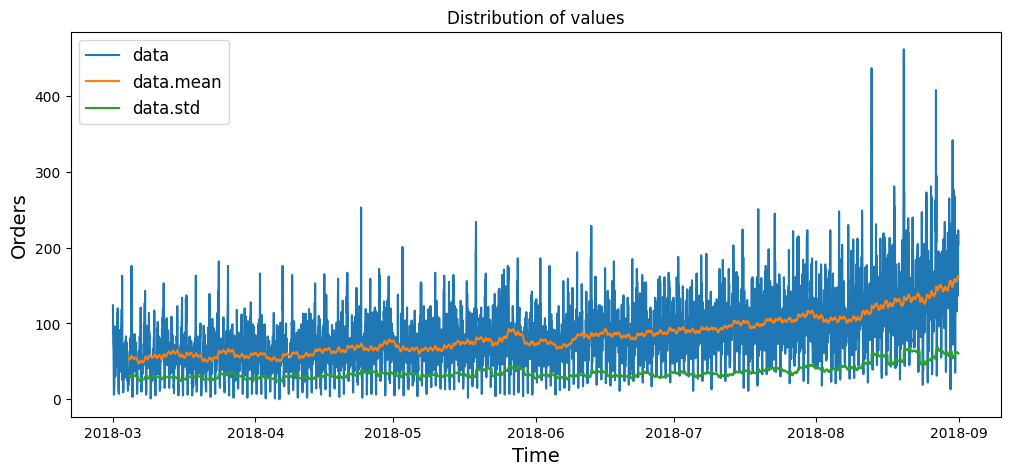

In [29]:
window = 84

plt.figure(figsize=(12, 5))

plt.plot(data, label = 'data')
plt.plot(data.rolling(window).mean(),  label = 'data.mean')
plt.plot(data.rolling(window).std(), label = 'data.std')

plt.xlabel('Time', size = 14)
plt.ylabel('Orders', size = 14)
plt.title('Distribution of values')

plt.legend(title = '', loc = 'upper left', fontsize = 12);

**Промежуточный вывод:**

Данные не статичны, так как в некоторых промежутках сильно изменяется стандартное отклонение. Видны тенденции, которые мы уточним в следующим пункте.

<div class="alert alert-block alert-success">
<b>Успех:</b> Данные загружены корректно, первичный осмотр проведен. Ресемплинг был сделан верно.
</div>

Разложим ряд на компоненты: тренд, сезонность и случайные колебания. Построим функцию `plot_trend_and_seasons`.

In [30]:
def plot_trend_and_seasons(date_from: str, date_to: str):
    pylab.rcParams['figure.figsize'] = (10, 7)
    seasonal_decompose(data[date_from:date_to]).plot()


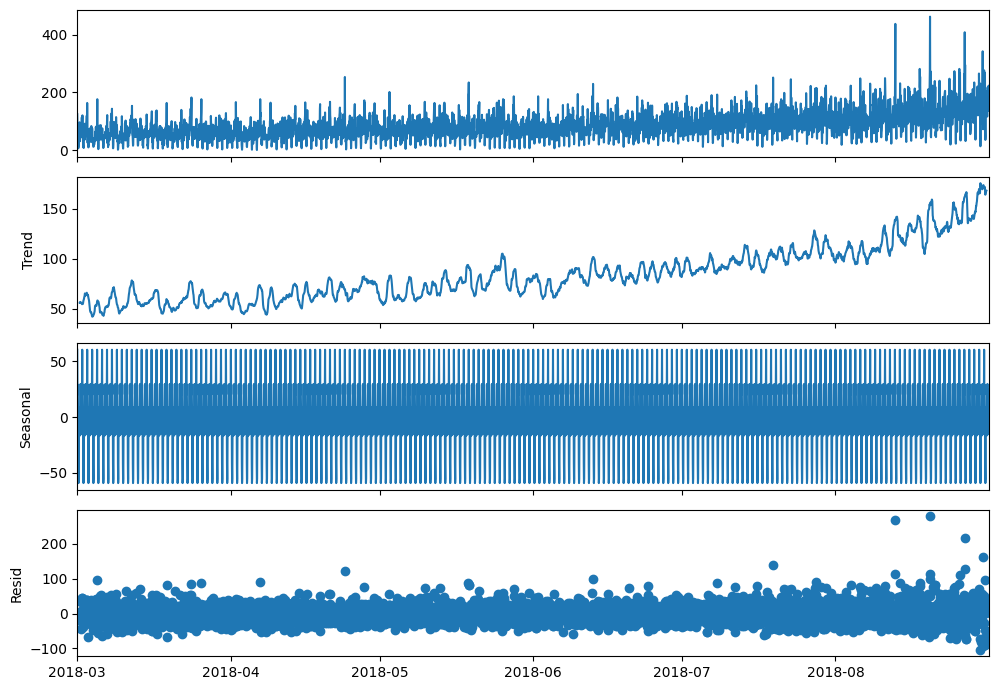

In [31]:
plot_trend_and_seasons('2018', '2018')

По графику сложно понять хоть какие-то зависимости, поэтому выберем промежуток в 2-е недели, чтобы увеличить масштаб.

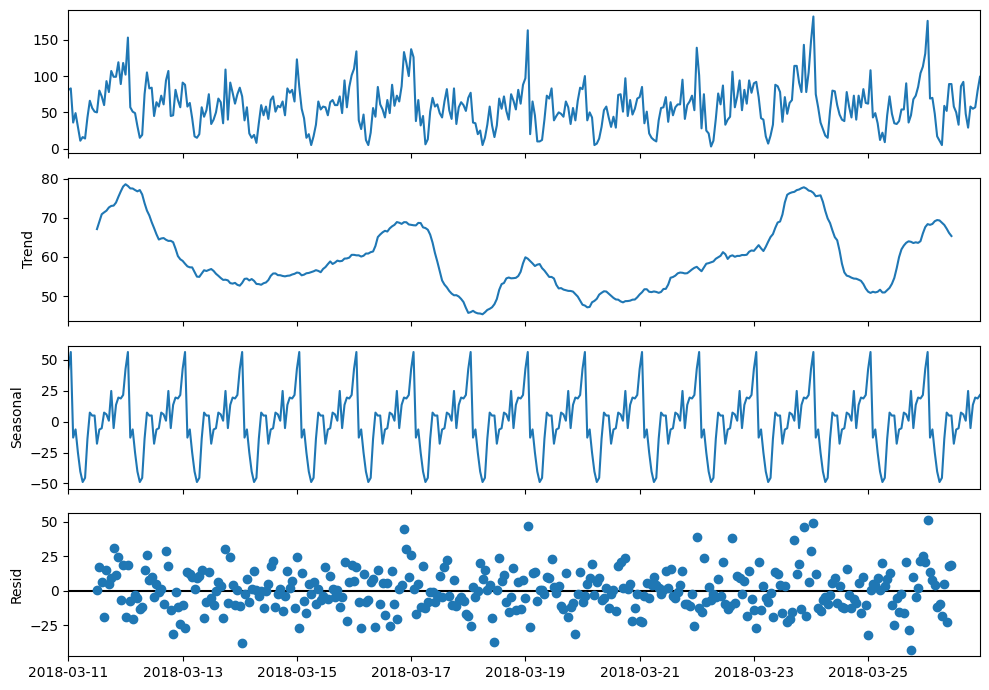

In [32]:
plot_trend_and_seasons('2018-03-11', '2018-03-26')

**Промежуточный вывод:**

Мы видим пики ближе к выходным, которые наблюдаются и в тренде, и в сезонности, что вполне объяснимо, ведь ближе к выходным люди проводят больше времени на улице и имеют возможность отдохнуть от работы, чем и обуславливается высокий спрос.

<div class="alert alert-block alert-success">
<b>Успех:</b> Декомпозиция была сделана верно. Хорошо, что сезонность была визуализирована на более коротком интервале!
</div>

<div class="alert alert-block alert-info">
<b>Совет: </b> Однако, желательно было сначала првоести декомпозицию всего ряда, а затем взять подотрезок.
</div>

<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b> Учту!
</div>

Построим матрицу автокорреляции и график.

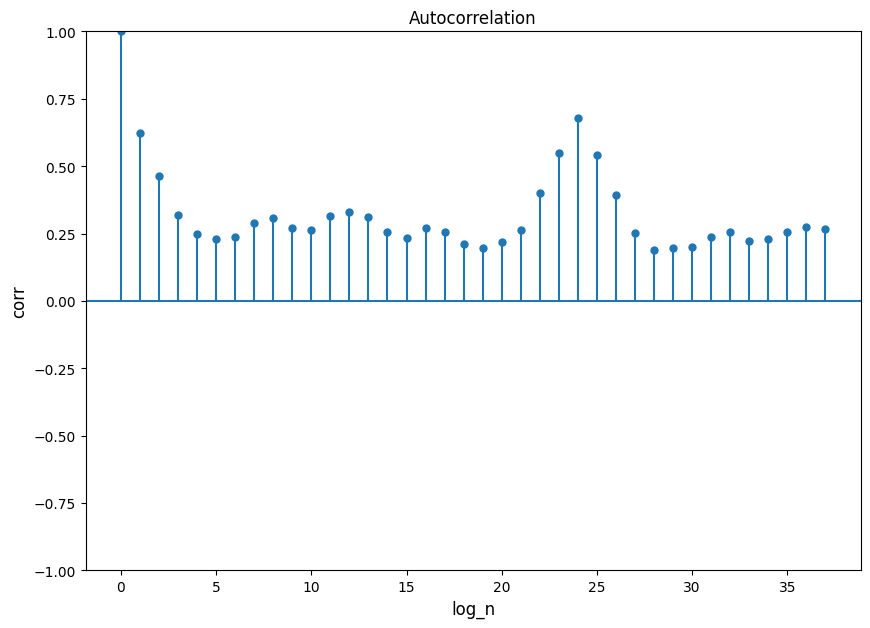

In [33]:
plot_acf(data, alpha=None)
plt.xlabel('log_n', size = 12)
plt.ylabel('corr', size = 12)
plt.show()

In [36]:
data.to_csv("data_main.csv")

**Промежуточный вывод:**

Как мы видим по пикам на логах `1-2`, `7-8`, `13-14`, `19-23`, ближе к выходным наблюдается прирост, что было доказано выше.

## Обучение моделей с разными гиперпараметрами.

Для начала необходимо добавить новые признаки, чтобы наша модель лучше обучалась. Создадим функцию `make_new_features`, которая добавляет:

* `day_of_week`
* `time`

In [65]:
def make_new_features(data: pd.DataFrame, max_lag: int, rolling_mean_size: float):
    data_features = data.copy()
    data_features['day_of_week'] = data_features.index.weekday
    data_features['time'] = data_features.index.hour

    for lag in range(1, max_lag + 1):
        data_features['lag_{}'.format(lag)] = data_features['num_orders'].shift(lag)

    data_features['rolling_mean'] = data_features['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data_features

In [66]:
data_with_features = make_new_features(data, 29, 168)

<div class="alert alert-block alert-info">

<b>Совет: </b> Желательно было написать функцию таким образом, чтобы она возвращала новый датафрейм, а не изменяла глобальную переменную.
1. Это хорошая практика (не изменять глобальные переменные внутри функции), которая улучшает читаемость кода.
2. В какой-то момент может появиться необходимость подбирать некоторые параметры используемый внутри функции. В этот момент копирование датасета станет обязательным.
</div>

<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b> Ой, иногда забываю про это, сейчас поправлю!
</div>

<div class="alert alert-block alert-warning">
<b>Изменения:</b> Функция возвращает копию DataFrame. 
</div>

<div class="alert alert-block alert-success">
<b>Успех (ревью 2):</b> Отлично!
</div>

Разделим выборку на обучающую и тестовую выборки.

In [67]:
data_train, data_test = train_test_split(data_with_features, test_size=.1, shuffle=False)
data_train = data_train.dropna()

Проверим корректность разреза данных.

In [68]:
print(data_train.index.min())
print(data_test.index.max())

Разрез корректен.

Разделим получившиеся выборки на признаки: `features`,`target`.

In [69]:
features_train = data_train.drop('num_orders', axis = 1)
target_train = data_train.num_orders

features_test = data_test.drop('num_orders', axis = 1)
target_test = data_test.num_orders

Данные разделены, теперь можно обучать.

Обучим разные модели.

**Простые модели:**
1. LinearRegression
2. DecisionTreeRegressor
3. RandomForestRegressor

**Модели на основе градиентного бустинга:**

1. LightGBM
2. CatBoost

<div class="alert alert-block alert-success">
<b>Успех:</b> Разбиение было сделано корректно.
</div>

Подготовим словари параметров для каждой модели.

In [70]:
param_grid_forest = {
    'n_estimators': range(1, 101, 20),
    'max_depth': range(2, 6),
    'min_samples_leaf': range(1, 5, 2),
    'min_samples_split': range(2, 6, 2)
}

param_grid_tree = {
    'max_depth': range(2, 6),
    'min_samples_leaf': range(1, 5, 2),
    'min_samples_split': range(2, 6, 2)
}

param_grid_linregr = {
              'fit_intercept': [True, False],
}

param_grid_catboost = {
    'n_estimators': range(1, 100, 25),
    'learning_rate': [0.03, 0.1],
    'depth': range(2, 6)
}

param_grid_lightgbm = {
    'n_estimators': range(1, 100, 25),
    'learning_rate': [0.1, 0.01]
}

params_grid_xgb = {
    "learning_rate": (0.05, 0.1),
    "max_depth": [ 3, 4, 5, 6, 8],
    "min_child_weight": [ 1, 3, 5, 7],
    "gamma":[ 0.0, 0.1, 0.2],
}

### Простые модели

Создадим модели, и подберем параметры с помощью `GridSearchCV`.

In [71]:
model_TREE = DecisionTreeRegressor(random_state=RANDOM_STATE)
model_FOREST = RandomForestRegressor(random_state=RANDOM_STATE)
model_LINREGR = LinearRegression()

In [72]:
%%time

cv = TimeSeriesSplit(3)

grid_TREEE = GridSearchCV(model_TREE, param_grid_tree, cv = cv, scoring='neg_mean_squared_error')
grid_TREEE.fit(features_train, target_train)

grid_FOREST = GridSearchCV(model_FOREST, param_grid_forest, cv = cv, scoring='neg_mean_squared_error')
grid_FOREST.fit(features_train, target_train)

grid_LINREGR = GridSearchCV(model_LINREGR, param_grid_linregr,  cv = cv, scoring='neg_mean_squared_error')
grid_LINREGR.fit(features_train, target_train)

print('Время подбора: \n')

<div class="alert alert-block alert-danger">
<b>Ошибка:</b> При работе с временными рядами нельзя использовать стандартную кросс-валидацию, так как в определенный момент тренировочная выборка окажется позже валидационной. Подробнее можно прочитать <a href ="https://towardsdatascience.com/4-things-to-do-when-applying-cross-validation-with-time-series-c6a5674ebf3a">тут</a>. Для решения этой проблемы стоит использовать <a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html">TimeSeriesSplit</a>. Объект этого типа можно передать в параметр cv в метод основанный на кросс-валидации.
</div>

<div class="alert alert-block alert-warning">
<b>Изменения:</b> Ипользована функция TimeSeriesSplit.
</div>

<div class="alert alert-block alert-success">
<b>Успех (ревью 2):</b> Верно, молодец!
</div>

Напишем функцию для расчета RMSE.

In [73]:
def rmse(mse: float):
    return math.sqrt(mse)

Модели обучены. Выведем подобранные параметры.

In [74]:
print(
    f'Модель DecisionTreeRegressor\n {grid_TREEE.best_params_}\nRMSE: {rmse((grid_TREEE.best_score_ * (-1)))}\n\n'
    f'Модель RandomForestRegressor\n {grid_FOREST.best_params_}\nRMSE: {rmse((grid_FOREST.best_score_ * (-1)))}\n\n'
    f'Модель LinearRegression\n: {grid_LINREGR.best_params_}\nRMSE: {rmse((grid_LINREGR.best_score_ * (-1)))}'
)

<div class="alert alert-block alert-danger">
<b>Ошибка:</b> В случае линейной модели нужно тоже провести кросс-валидацию, чтобы результаты были сравнимы.
</div>

<div class="alert alert-block alert-warning">
<b>Изменения:</b> Добавлена кросс-валидация для линейной регрессии.
</div>

<div class="alert alert-block alert-success">
<b>Успех (ревью 2):</b> ОК.
</div>

### Модели на основе градиентного бустинга

In [75]:
model_catboost = cb.CatBoostRegressor(random_state=RANDOM_STATE)
model_lightgbm = lgb.LGBMRegressor(random_state=RANDOM_STATE)
xgb_model = xgb.XGBRegressor(random_state = RANDOM_STATE)

In [76]:
%%time

grid_catboost = GridSearchCV(estimator=model_catboost,
                             param_grid=param_grid_catboost,
                             cv = cv,
                             n_jobs=-1,
                             scoring='neg_mean_squared_error')
grid_catboost.fit(features_train, target_train, verbose = False)

grid_lightgbm = GridSearchCV(estimator=model_lightgbm,
                             param_grid=param_grid_lightgbm,
                             cv = cv,
                             n_jobs=-1,
                             scoring='neg_mean_squared_error')
grid_lightgbm.fit(features_train, target_train, verbose = False)

grid_xgb = GridSearchCV(estimator=xgb.XGBRegressor(), 
                        param_grid=params_grid_xgb, 
                        scoring='neg_mean_squared_error')
grid_xgb.fit(features_train, target_train)

print('Время подбора:\n')

In [77]:
print(
    f'Модель CatBoostRegressor\n {grid_catboost.best_params_}\nRMSE: {rmse(grid_catboost.best_score_ * (-1))}\n\n'
    f'Модель LGBMRegressor\n {grid_lightgbm.best_params_}\nRMSE: {rmse(grid_lightgbm.best_score_ * (-1))} \n\n'
    f'Модель XGBRegressor\n {grid_xgb.best_params_}\nRMSE: {rmse(grid_xgb.best_score_ * (-1))}'
)

<div class="alert alert-block alert-danger">
<b>Ошибка:</b> По умолчанию считается R2, а не RMSE. Нужно изменить параметр scoring, как ты и делал ранее.
</div>

<div class="alert alert-block alert-warning">
<b>Изменения:</b> Добавлен параметр scoring - neg_mean_squared_error.
</div>

<div class="alert alert-block alert-success">
<b>Успех (ревью 2):</b> Спасибо!
</div>

**Вывод:**

По итогам исследования наилучшая модель - `XGBRegressor`.

Парамтеры: {'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 7}


## Проанализируем время обучения и проверим значения на тестовой выборке

Для анализа времени обучения - создадим класс `Time`.

In [78]:
class Time:
    def __init__(self, model, model_name = ''):
        self.model = model
        self.model_name = model_name
        self.train_time = None
        self.predicts = None
        self.predict_time = None
        self.rmse = None

    def set_fit_time(self, features_time, target_time):
        start = time.time()
        self.model.fit(features_time, target_time)
        finish = time.time()
        self.train_time = finish - start

    def set_predict_time(self):
        start = time.time()
        self.predicts = self.model.predict(features_test)
        end = time.time()
        self.predict_time = end - start

    def set_quality(self):
        self.rmse = rmse(mean_squared_error(target_test, self.predicts))


Создадим экземпляры класса для выбранной модели модели.

In [79]:
model_xgb_time = Time(xgb.XGBRegressor(gamma =  0.0, learning_rate =  0.1, max_depth = 4, min_child_weight = 5), 'XGBRegressor')
model_xgb_time.set_fit_time(features_train, target_train)
model_xgb_time.set_predict_time()
model_xgb_time.set_quality()

Составим таблицу качества и времени обучения. Для этого напишем функцию.

In [80]:
exemplars_time_models = [model_xgb_time]
def print_table():
    print('|{: >23}|{: >18}|{: >18}|{: >12}|'.format('Модель', 'Время обучения', 'Время предсказания', 'RMSE'))
    for model in exemplars_time_models:
        print('|{: >23}|{: >18.5f}|{: >18.5f}|{: >12.5f}|'.format(model.model_name, model.train_time, model.predict_time, model.rmse))

In [81]:
print_table()

## Вывод

Обученные модели дали следующие результаты:

* **DecisionTreeRegressor**:

rmse_train - 29.2404

rmse_test - 51.2256

+------------------------+

* **RandomForestRegressor**:

rmse_train - 26.8558

rmse_test - 47.4170

+------------------------+

* **LinearRegression**:

rmse_train - 25.3993

rmse_test - 44.5958

+------------------------+

+------------------------+

* **CatBoostRegressor**:

rmse_train - 25.3383

rmse_test - 46.6397

+------------------------+

* **LGBMRegressor**:

rmse_train - 25.3383

rmse_test - 40.0952

+------------------------+

* **XGBRegressor**:

rmse_train - 25.3383

rmse_test - 40.5814


Из всех моделей лучше всего показали себя **градиентные**. Однако, лучшая модель `LGBMRegressor`

<div class="alert alert-block alert-info">
<b>Совет (ревью 2): </b> Не забывай исправлять вывод после исправления ошибок.
</div>

<div class="alert alert-block alert-success">
<b>Успех:</b> Приятно видеть вывод в конце проекта!
</div>